# NBA Game Outcome Prediction
Projects objective is to predict future game winners by historical NBA game data.

**Team Total Features**:
- `Basic Stats`:
    - mp = Minutes Played
    - fg = Field Goals
    - fga = Field Goal Attempts
    - fg% = Field Goal Percentage
    - 3p = 3 Point field goals
    - 3pa = 3 Point field goal attempts
    - 3p% = 3 Point Field Goal Percentage
    - ft = Free Throw
    - fta = Free Throw Attempts
    - ft% = Free Throw Percentage
    - orb = Offensive Rebounds
    - drb = Defensive Rebounds
    - trb = Total Rebounds
    - ast = Assists
    - stl = Steal
    - blk = Blocks
    - tov = Turnovers
    - pf = Personal Fouls
    - pts = Points
- `Advanced Stats`
    - ts% = True shooting percentage
    - efg% = Effective field Goal percentage
    - 3par = 3-point attempt rate
    - ftr = free throw attempt rate
    - orb% = defensive rebound percentage
    - trb% = total rebound percentage
    - ast% = assist percentage
    - stl% = steal percentage
    - blk% = block percentage
    - tov% = Turnovers percentage
    - usg% = Usage Percentage
    - ortg = Offensive Rating
    - drtg = Deffensive Rating

## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

import datetime
from datetime import date
import matplotlib.dates as mdates
import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow

import warnings

pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

## READ INTO DF

In [4]:
df = pd.read_csv(f'Historical Data/games_until_') # Enter the path to the last fully loaded dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22814 entries, 0 to 22813
Columns: 150 entries, mp to won
dtypes: bool(1), float64(140), int64(6), object(3)
memory usage: 26.0+ MB


### Baseline Accuracy

In [5]:
df.groupby(['home']).apply(lambda x: x[x['won'] == 1].shape[0]/ x.shape[0], include_groups=False)

home
0    0.43035
1    0.56965
dtype: float64

Baseline accuracy is 57% 

## Data Preprocessing PipeLine

In [6]:
# Because the target is the prediction of team`s next game 'win or lose' situation, shift 'won' column by -1
def add_target(team):
    team['target'] = team['won'].shift(-1)
    return team

In [7]:
def shift_column(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

def add_column(df, col_name):
    return df.groupby('team', group_keys=False).apply(lambda x: shift_column(x, col_name))

In [8]:
def get_info(game_count):
    games_dict = {}
    
    timedelta = datetime.timedelta(days=2)
    tomorrow = date.today() + timedelta
    game_date = tomorrow.strftime('%Y-%m-%d')
    
    for i in range(game_count):
        print(f'{i + 1}. Game:')
        home_team = input('Enter the Home Team: ')
        away_team = input('Enter the Away Team: ')
        #game_date = '2024-04-05' #input('Enter the Game Date (YYYY-MM-DD): ')
        games_dict[f'{home_team}-{away_team}'] = {
            'home_team': home_team,
            'away_team': away_team, 
            'game_date': game_date,
        }
    return games_dict

In [9]:
def fill_game_data(df, games_dict):
    df = df.copy()

    for key in games_dict:
        # Initialize Game info for this particular game
        home_team = games_dict[key]['home_team']
        away_team = games_dict[key]['away_team']
        game_date = games_dict[key]['game_date']

        # Get indexes of home & away pov
        home_index = df[(df['target'] == 2) & (df['team'] == home_team)].index[0]
        away_index = df[(df['target'] == 2) & (df['team'] == away_team)].index[0]
    
        # Fill for home team
        df.at[home_index, 'team_opp_next'] = away_team
        df.at[home_index, 'home_next'] = 1
        df.at[home_index, 'date_next'] = game_date
    
        # Fill for away team
        df.at[away_index, 'team_opp_next'] = home_team
        df.at[away_index, 'home_next'] = 0
        df.at[away_index, 'date_next'] = game_date
    
        print(f'\n\nGame: {key}')
        print(df.iloc[[home_index, away_index]][['team', 'team_opp', 'date', 'team_opp_next', 'date_next']])
        print('\n\n')
    return df

In [10]:
def update_elo(win_team, lose_team, elo_ratings, last_season_dict, current_season, mov):
    # Season reset for win_team
    if current_season != last_season_dict[win_team]:
        elo_ratings[win_team] = (elo_ratings[win_team] * 0.75) + (1500 * 0.25)
        last_season_dict[win_team] = current_season

    # Season reset for lose_team
    if current_season != last_season_dict[lose_team]:
        elo_ratings[lose_team] = (elo_ratings[lose_team] * 0.75) + (1500 * 0.25)
        last_season_dict[lose_team] = current_season

    # Update Elo ratings based on the game outcome
    Ra = elo_ratings[win_team]
    Rb = elo_ratings[lose_team]
    Ea = 1 / (1 + 10 ** ((Rb - Ra) / 400))
    Eb = 1 - Ea
    
    elo_difference = Ra - Rb
    k = (20 * (mov + 3)**0.8) / (7.5 + 0.006 * elo_difference) # Constant
    
    elo_ratings[win_team] = Ra + k * (1 - Ea)
    elo_ratings[lose_team] = Rb + k * (0 - Eb)

    return elo_ratings, last_season_dict

In [11]:
def elo_handler(df):
    # Initialize Elo ratings
    teams = df['team'].unique()
    elo_ratings = {team: 1500 for team in teams}
    
    # Create a unique identifier for each game
    df['game_id'] = df.apply(lambda x: '_'.join(sorted([x['team'], x['team_opp']])) + '_' + x['date'], axis=1)
    
    # Initialize columns for pre-game Elo ratings
    df['elo_pre_game'] = 0
    df['opp_elo_pre_game'] = 0

    # Initialize last season played game season for teams
    last_season_dict = {team: 2016 for team in teams}
    
    # Main loop 
    for game_id in df['game_id'].unique():
        game_rows = df[df['game_id'] == game_id]
        for index, row in game_rows.iterrows():
            team, opp = row['team'], row['team_opp']
            
            # Assign pre-game Elo ratings
            df.at[index, 'elo_pre_game'] = elo_ratings[team]
            df.at[index, 'opp_elo_pre_game'] = elo_ratings[opp]

        # Update Elo ratings for both teams involved in the game
        won_pov = game_rows[game_rows['won'] == 1]
        mov = won_pov['total'].values[0] - won_pov['total_opp'].values[0]
        elo_ratings, last_season_dict = update_elo(won_pov['team'].values[0], won_pov['team_opp'].values[0], elo_ratings, last_season_dict, won_pov['season'].values[0], mov)

    df = df.drop(['game_id'], axis=1)
    return df

In [12]:
def find_team_averages(team, rolling_window):
    numeric_cols = team.select_dtypes(include=['number', 'bool']).drop(['some_id_or_binary_columns'], axis=1, errors='ignore')
    rolling = numeric_cols.rolling(rolling_window, min_periods=1).mean()

    rolling_renamed = rolling.add_suffix(f'_{rolling_window}')
    
    #team_updated = pd.concat([team, rolling_renamed], axis=1)
    team_updated = rolling_renamed.drop(f'season_{rolling_window}', axis=1)
    return team_updated

def add_rolling_data(df_rolling, rolling_window):
    df_copy = df_rolling.copy()
    df_copy = df_copy.groupby(['team', 'season'], group_keys=False).apply(lambda x: find_team_averages(x, rolling_window))

    rolling_cols = [col for col in df_copy.columns if f'_{rolling_window}' in col]

    return df_copy, rolling_cols

def add_rolling_columns(df, df_rolling):
    merged_df = pd.concat([df, df_rolling], axis=1)

    return merged_df

In [13]:
def find_team_averages_conditional(team, rolling_window, metrics):
    # Initialize a dictionary to store lists for each rolling average
    rolling_data = {f'{col}_{rolling_window}': [] for col in metrics}
    
    for idx, row in team.iterrows():
        if row['home_next'] == 1:
            past_games = team[(team['home'] == 1) & (team['date'] < row['date'])]
        else:
            past_games = team[(team['home'] == 0) & (team['date'] < row['date'])]

        for col in metrics:
            col_name = f'{col}_{rolling_window}'
            if not past_games.empty:
                # Calculate the last value of rolling average if past_games is not empty
                rolling_avg_last_value = past_games[col].rolling(window=rolling_window, min_periods=1).mean().iloc[-1]
                rolling_data[col_name].append(rolling_avg_last_value)
            else:
                # Append NaN if past_games is empty
                rolling_data[col_name].append(np.nan)
                
    # Convert the dictionary into a DataFrame
    rolling_df = pd.DataFrame(rolling_data, index=team.index)
    return rolling_df


def add_conditional_rolling_data(df, rolling_window, metrics):
    df_copy = df.copy()
    conditional_rolling_results = df_copy.groupby(['team'], group_keys=False).apply(lambda x: find_team_averages_conditional(x, rolling_window, metrics))
    
    df_copy = pd.concat([df_copy, conditional_rolling_results], axis=1)
    
    return df_copy

In [14]:
def calculate_wr_next_opp(team):
    team['wr_against_team_opp_next'] = np.nan
    
    for index, row in team.iterrows():
        next_opp = row['team_opp_next']
        date = row['date']

        if pd.isna(next_opp):
            continue

        previous_matches_against_next_opponent = team[(team['team_opp'] == next_opp) & (team['date'] < date)]

        if not previous_matches_against_next_opponent.empty:
            wr = previous_matches_against_next_opponent['won'].mean()
        else:
            wr = 50
            
        team.at[index, 'wr_against_team_opp_next'] = wr
    return team

In [15]:
def calculate_wr_against_next_opponent_this_season(team):
    team_name, season = team.name
    # Initialize a column for win rate against next opponent this season with NaNs.
    team['wr_against_team_opp_next_this_season'] = np.nan
    
    # Iterate through each row in the DataFrame to calculate the win rate against the next opponent.
    for index, row in team.iterrows():
        next_opponent = row['team_opp_next']
        date = row['date']
        key = f'{team_name} vs {next_opponent}'
        
        if pd.isna(next_opponent):
            continue  # Skip if there's no next opponent listed.
        
        # Filter for games against the next opponent up to the current date.
        previous_matches_against_next_opponent = team[(team['team_opp'] == next_opponent) & (team['date'] < date)]
        
        # Calculate win rate.
        if not previous_matches_against_next_opponent.empty:
            won_games = previous_matches_against_next_opponent['won'].sum()
            total_games = len(previous_matches_against_next_opponent)
            win_rate = (won_games / total_games) * 100
        else:
            win_rate = 50
            
        team.at[index, 'wr_against_team_opp_next_this_season'] = win_rate

    return team

In [16]:
def calculate_home_away_wr(team):
    team['home_wr'] = np.nan
    team['away_wr'] = np.nan

    for index, row in team.iterrows():
        home = row['home']
        date = row['date']
                    
        previous_matches = team[(team['date'] < date)]
        
        home_matches = previous_matches[previous_matches['home'] == 1]
        away_matches = previous_matches[previous_matches['home'] == 0]

        if not home_matches.empty:
            home_wr = home_matches['won'].mean()

        if not away_matches.empty:
            away_wr = away_matches['won'].mean()

        if away_matches.empty and home_matches.empty:
            home_wr = away_wr = 50
        
        team.at[index, 'home_wr'] = home_wr
        team.at[index, 'away_wr'] = away_wr

    return team

In [17]:
def calculate_win_streak(team):
    win_streak = 0
    win_streaks = []
    
    for win in team['won']:
        if win:
            win_streak += 1
        else:
            win_streak = 0
            
        win_streaks.append(win_streak)
    team['win_streak'] = win_streaks
    return team

def add_win_streak(df):
    return df.groupby('team', group_keys=False).apply(calculate_win_streak)

def calculate_hotness(x):
    if x >= 3:
        return 1
    else:
        return 0

In [18]:
def calculate_lose_streak(team):
    lose_streak = 0
    lose_streaks = []
    
    for win in team['won']:
        if not win:
            lose_streak += 1
        else:
            lose_streak = 0
            
        lose_streaks.append(lose_streak)
    team['lose_streak'] = lose_streaks
    return team

def add_lose_streak(df):
    return df.groupby('team', group_keys=False).apply(calculate_lose_streak)

def calculate_coldness(x):
    if x >= 3:
        return 1
    else:
        return 0

In [19]:
def get_games_to_predict(df, games_dict):
    games = []
    for key in games_dict:
        # Initialize Game info for this particular game
        home_team = games_dict[key]['home_team']
        away_team = games_dict[key]['away_team']
        game_date = games_dict[key]['game_date']

        # Get Games
        game_home = df[(df['team_x'] == home_team) & (df['team_y'] == away_team)].tail(1)
        game_away = df[(df['team_x'] == away_team) & (df['team_y'] == home_team)].tail(1)

        # Get Indexes
        home_index = game_home.index[0]
        away_index = game_away.index[0]

        # Drop the games from main df
        df = df.drop([home_index, away_index], axis=0)

        # Append game to games
        game = pd.concat([game_home, game_away], axis=0)
        games.append(game)
            
    games_df = pd.concat(games, axis=0)
    print(games_df[['team_x', 'team_y', 'date_next']])
    return games_df, df

In [20]:
def preprocess(df):
    df = df.copy()

    # ======================== DATA CLEANING ======================== #
    # Sort Values According to Dates
    df = df.sort_values('date')
    df = df.reset_index(drop=True)

    # Drop duplicate & Unnecesary columns
    df = df.drop(['mp.1', 'mp_opp.1', 'index_opp'], axis=1)

    # Add Target Column
    df = df.groupby('team', group_keys=False).apply(add_target)

    # Assign target null values to 2, True to 1, False to 0
    df['target'] = df['target'].fillna(2)
    df['target'] = df['target'].astype(int, errors='ignore')

    # Remove Null Columns
    nulls = pd.isnull(df).sum()
    nulls = nulls[nulls > 0]
    if len(nulls) > 7:
        print('There are more then expected Nulls.')
    df = df.drop(nulls.index, axis=1)    

    # ======================== FUTURE COLUMNS ======================== #
    # Add Necessary Columns to predict Future
    df['home_next'] = add_column(df, 'home')
    df['team_opp_next'] = add_column(df, 'team_opp')
    df['date_next'] = add_column(df, 'date')

    # ======================== GAMES TO PREDICT ======================== #
    # Get information of future games to predict
    game_count = int(input('How many games you want to predict? '))
    games_dict = get_info(game_count) 
    
    # Fill the future game to predict
    df = fill_game_data(df, games_dict)

    # ======================== ELO CALCULATION ======================== #
    df = elo_handler(df)
    elo_df = df[['team', 'team_opp', 'team_opp_next', 'elo_pre_game', 'date']].copy()
   
    # ======================== CALCULATION OF AVERAGE SCORES OVER LAST X GAMES ======================== #
    # Add Rolling Data (Past games average for every team) 
    removed_columns = ['date', 'season', 'won', 'target', 'team', 'team_opp', 'team_opp_next', 'home_next', 'date_next']
    selected_columns = df.columns[~df.columns.isin(removed_columns)]
    
    df_rolling = df[list(selected_columns) + ['won', 'team', 'season']]

    df_rolling_20, rolling_20_cols = add_rolling_data(df_rolling, 20)
    df_rolling_10, rolling_10_cols = add_rolling_data(df_rolling, 10)

    df = add_rolling_columns(df, df_rolling_20)
    df = add_rolling_columns(df, df_rolling_10)
    df = df.dropna()

    # rolling_window = 20
    # df = add_conditional_rolling_data(df, rolling_window, selected_columns)
    # rolling_cols = [f'{col}_20' for col in selected_columns]
    # df = df.dropna()

    # ======================== CALCULATION OF WINRATES ======================== #
    # Calculate Winrate against next opponent
    df = df.groupby(['team'], group_keys=False).apply(calculate_wr_next_opp)

    # Calculate Winrate against nex opponent for current season
    df = df.groupby(['team', 'season'], group_keys=False).apply(calculate_wr_against_next_opponent_this_season)

    # Calculate Home & Away Winrates
    df = df.groupby(['team'], group_keys=False).apply(calculate_home_away_wr)
    
    # Calculate Win Streak & Hotness of team
    df = add_win_streak(df)
    df['hot'] = df['win_streak'].apply(calculate_hotness)

    # Calculate Lose Streak & Coldness of team
    df = add_lose_streak(df)
    df['cold'] = df['lose_streak'].apply(calculate_coldness)    

    # ======================== FEATURE ENGINEERING ======================== #
    # Mixture of features
    df['win_streak_x_home_next'] = df['win_streak'] * df['home_next']
    df['home_away_wr'] = (df['home_wr'] * df['home_next']) + (df['away_wr'] * (1 - df['home_next']))
    df['home_away_wr_x_wr_against_next_opp'] = df['home_away_wr'] * df['wr_against_team_opp_next']
    #df['odr'] = df['drtg'] defansif ofansif rating ekle
    
    # ======================== DATA SCALING ======================== #
    # Scale Columns
    removed_columns = ['date', 'season', 'won', 'target', 'team', 'team_opp', 'team_opp_next', 'date_next', 'home_next', 'hot', 'cold', 'home_away_wr',
                      'home_away_wr_x_wr_against_next_opp', 'home_wr', 'away_wr']
    selected_columns = df.columns[~df.columns.isin(removed_columns)]

    scaler = MinMaxScaler()
    df[selected_columns] = scaler.fit_transform(df[selected_columns])

    # ======================== MERGE WITH NEXT OPPONENTS STATS ======================== #
    # Merge With team_opp_next to get their stats in one row aswell
    full_df = df.merge(
    df[rolling_20_cols + rolling_10_cols + ['team_opp_next', 'date_next', 'team', 'elo_pre_game']], #
    left_on=['team', 'date_next'],
    right_on=['team_opp_next', 'date_next']
    )
    
    full_df['elo_difference'] = full_df['elo_pre_game_x'] - full_df['elo_pre_game_y']
    
    # ======================== FINAL ======================== #
    # Get game to predict
    games_df, full_df = get_games_to_predict(full_df, games_dict)
    return full_df, games_df, games_dict, elo_df

In [21]:
processed_df, games_df, games_dict, elo_df = preprocess(df)

How many games you want to predict?  5


1. Game:


Enter the Home Team:  PHI
Enter the Away Team:  ORL


2. Game:


Enter the Home Team:  WAS
Enter the Away Team:  CHI


3. Game:


Enter the Home Team:  BOS
Enter the Away Team:  CHO


4. Game:


Enter the Home Team:  IND
Enter the Away Team:  CLE


5. Game:


Enter the Home Team:  NYK
Enter the Away Team:  BRK




Game: PHI-ORL
      team team_opp        date team_opp_next   date_next
22764  PHI      DET  2024-04-09           ORL  2024-06-12
22791  ORL      MIL  2024-04-10           PHI  2024-06-12





Game: WAS-CHI
      team team_opp        date team_opp_next   date_next
22773  WAS      MIN  2024-04-09           CHI  2024-06-12
22809  CHI      DET  2024-04-11           WAS  2024-06-12





Game: BOS-CHO
      team team_opp        date team_opp_next   date_next
22808  BOS      NYK  2024-04-11           CHO  2024-06-12
22802  CHO      ATL  2024-04-10           BOS  2024-06-12





Game: IND-CLE
      team team_opp        date team_opp_next   date_next
22769  IND      TOR  2024-04-09           CLE  2024-06-12
22797  CLE      MEM  2024-04-10           IND  2024-06-12





Game: NYK-BRK
      team team_opp        date team_opp_next   date_next
22810  NYK      BOS  2024-04-11           BRK  2024-06-12
22799  BRK      TOR  2024-04-10           NYK  2024-06-12



      team_x team_y   date_next
227

7. Game:


Enter the Home Team:  PHI
Enter the Away Team:  BRK


8. Game:


Enter the Home Team:  GSW
Enter the Away Team:  UTA


9. Game:


Enter the Home Team:  LAC
Enter the Away Team:  HOU


10. Game:


Enter the Home Team:  MEM
Enter the Away Team:  DEN


11. Game:


Enter the Home Team:  MIN
Enter the Away Team:  PHO


12. Game:


Enter the Home Team:  NOP
Enter the Away Team:  LAL


13. Game:


Enter the Home Team:  OKC
Enter the Away Team:  DAL


14. Game:


Enter the Home Team:  SAC
Enter the Away Team:  POR


15. Game:


Enter the Home Team:  SAS
Enter the Away Team:  DET




Game: BOS-WAS
      team team_opp        date team_opp_next   date_next
22839  BOS      CHO  2024-04-12           WAS  2024-04-16
22843  WAS      CHI  2024-04-12           BOS  2024-04-16





Game: CLE-CHO
      team team_opp        date team_opp_next   date_next
22837  CLE      IND  2024-04-12           CHO  2024-04-16
22840  CHO      BOS  2024-04-12           CLE  2024-04-16





Game: IND-ATL
      team team_opp        date team_opp_next   date_next
22838  IND      CLE  2024-04-12           ATL  2024-04-16
22827  ATL      MIN  2024-04-12           IND  2024-04-16





Game: MIA-TOR
      team team_opp        date team_opp_next   date_next
22842  MIA      TOR  2024-04-12           TOR  2024-04-16
22829  TOR      MIA  2024-04-12           MIA  2024-04-16





Game: NYK-CHI
      team team_opp        date team_opp_next   date_next
22815  NYK      BRK  2024-04-12           CHI  2024-04-16
22841  CHI      WAS  2024-04-12           NYK  2024-04-16





Game: ORL-MIL
      team team_opp

In [22]:
def backtest_with_feature_importance(data, model, predictors, start=2, step=1):
    """ Backtest function to get feature importance """
    all_predictions = []
    feature_importances = pd.DataFrame(index=predictors)

    seasons = sorted(data['season'].unique())

    for i in range(start, len(seasons), step):
        season = seasons[i]

        train = data[data['season'] < season]
        test = data[data['season'] == season]

        model.fit(train[predictors], train['target'])

        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test['target'], preds], axis=1)
        combined.columns = ['actual', 'prediction']
        
        all_predictions.append(combined)

        # Extract feature importance from the model, ensure compatibility across model types
        if hasattr(model, 'feature_importances_'):
            season_importance = pd.Series(model.feature_importances_, index=predictors)
        else:  # For models that do not have feature_importances_ attribute
            season_importance = pd.Series([0]*len(predictors), index=predictors)
        
        feature_importances[f'season_{season}'] = season_importance

    # Calculate the mean importance across all seasons
    feature_importances['mean_importance'] = feature_importances.mean(axis=1)
    feature_importances = feature_importances.sort_values(by='mean_importance', ascending=False)
    
    return pd.concat(all_predictions), feature_importances

In [60]:
rr_predictors = ['orb_max', 'ast%_max', '3p%_opp', 'ft%_opp', 'drb_opp', 'ts%_opp', 'orb%_opp', 'trb%_opp', '3pa_10_x', 'ast_10_x', 'ft_max_10_x',
             'pts_max_10_x', 'orb%_max_10_x', 'drb%_max_10_x', 'blk%_opp_10_x', 'orb_max_opp_10_x', 'fg_10_y', '3pa_10_y', 'ft_max_10_y', 
             '3p%_opp_10_y', 'ft_opp_10_y', 'blk%_opp_10_y', 'ft_max_opp_10_y', '+/-_max_opp_10_y', 'total_opp_10_y', 'wr_against_team_opp_next',
             'home_next', 'hot', 'cold', 'efg%_20_x',
             '3pa_20_x', 'ast_20_x', 'ft_max_20_x', 'pts_max_20_x', 'orb%_max_20_x', 'drb%_max_20_x', 'blk%_opp_20_x','orb_max_opp_20_x',
             'total_opp_20_x', 'fg_20_y', '3pa_20_y', 'ft_max_20_y', 'pts_max_20_y', 'ast%_max_20_y', '3p%_opp_20_y', 'ft_opp_20_y', 'blk%_opp_20_y',
             'ft_max_opp_20_y', '+/-_max_opp_20_y', 'total_opp_20_y', '+/-_max_20_x',  '+/-_max_20_y', '+/-_max_opp_20_x', 'drtg_max_opp_20_x',
             '+/-_max_10_x', '+/-_max_10_y', '+/-_max_opp_10_x', 'drtg_max_opp_10_x', 'efg%_10_x', 'elo_pre_game_x', 'elo_pre_game_y',
             ]

xgb_predictors = [
       'elo_pre_game_y', 'elo_pre_game_x', '+/-_max_20_y', '+/-_max_opp_20_y',
       '+/-_max_opp_20_x', '+/-_max_20_x', '+/-_max_opp_10_y', '+/-_max_10_y',
       'home_next', '+/-_max_10_x', '+/-_max_opp_10_x', 'pts_max_20_y',
       'efg%_20_x', 'total_opp_20_x', 'ast%_max_20_y', 'drtg_max_opp_20_x',
       'efg%_10_x', 'ast%_max', 'blk%_opp_20_y', 'blk%_opp_20_x',
       'blk%_opp_10_y', 'ft%_opp', '3p%_opp_10_y', '3p%_opp_20_y',
       'pts_max_20_x', 'trb%_opp', 'drb%_max_10_x', 'blk%_opp_10_x',
       'drtg_max_opp_10_x', 'total_opp_20_y',
    
]

removed_columns = list(processed_df.columns[processed_df.dtypes == 'object']) +  list(['date', 'season', 'won', 'target', 'team', 'team_opp'])
selected_columns = processed_df.columns[~processed_df.columns.isin(removed_columns)]

#rr = RidgeClassifier()

#xgb = XGBClassifier()
#predictions, feature_importances = backtest_with_feature_importance(processed_df, xgb, selected_columns)


In [24]:
def backtest(data, model, predictors, start=2, step=1):
    """ Backtest function to look at model accuracies """
    all_predictions = []

    seasons = sorted(data['season'].unique())

    for i in range(start, len(seasons), step):
        season = seasons[i]

        train = data[data['season'] < season]
        test = data[data['season'] == season]

        model.fit(train[predictors], train['target'])

        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)

        combined = pd.concat([test['target'], preds], axis=1)
        combined.columns = ['actual', 'prediction']
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

## HyperParameter Tuning with Optuna

In [25]:
def rr_objective(trial, df, predictors):
    # Suggest hyperparameters
    param = {
        'alpha': trial.suggest_float('alpha', 0.0001, 10.0, log=True)
    }
    
    # Initialize model with suggested parameters
    model = RidgeClassifier(**param)
    
    # Use the backtest function to evaluate the model
    results = backtest(df, model, predictors)
    
    # Calculate average accuracy across all seasons
    results['correct'] = results['actual'] == results['prediction']
    accuracy = results['correct'].mean()
    
    return accuracy

In [26]:
def xgb_objective(trial, df, predictors):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    
    # Initialize model with suggested parameters
    model = XGBClassifier(**param)
    
    # Use the backtest function to evaluate the model
    results = backtest(df, model, predictors)
    
    # Calculate average accuracy across all seasons
    results['correct'] = results['actual'] == results['prediction']
    accuracy = results['correct'].mean()
    
    return accuracy

In [27]:
def logreg_objective(trial, df, predictors):
    # Suggest hyperparameters for LogisticRegression
    param = {
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    }
    
    # Initialize LogisticRegression with suggested parameters
    model = LogisticRegression(**param, random_state=42)

    # Use the backtest function to evaluate the model
    results = backtest(df, model, predictors)
    
    # Calculate average accuracy across all seasons
    results['correct'] = results['actual'] == results['prediction']
    accuracy = results['correct'].mean()
    
    return accuracy

In [28]:
# RR HyperParameter Tuning
def rr_hyperparameter_tuning(processed_df, selected_columns):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: rr_objective(trial, processed_df, selected_columns), n_trials=300)
    
    best_params = study.best_trial.params
    print("Best params:", best_params)

# XGB HyperParameter Tuning
def xgb_hyperparameter_tuning(processed_df, selected_columns):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: xgb_objective(trial, processed_df, selected_columns), n_trials=300)
    
    best_params = study.best_trial.params
    print("Best params:", best_params)

def logreg_hyperparameter_tuning(df, predictors):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: logreg_objective(trial, df, predictors), n_trials=100)
    
    best_params = study.best_trial.params
    print("Best params:", best_params)

#rr_hyperparameter_tuning(processed_df, rr_predictors)
rr = RidgeClassifier(alpha=0.9057344254190455)
    
#xgb_hyperparameter_tuning(processed_df, xgb_predictors)
xgb = XGBClassifier(reg_lambda=  0.005493550813162956,
                    alpha= 0.11711953180019787,
                    colsample_bytree= 0.5856632844701086,
                    subsample= 0.5888723418968987,
                    learning_rate= 0.015070807283932237,
                    n_estimators= 599,
                    max_depth= 8,
                    min_child_weight= 245)

#logreg_hyperparameter_tuning(processed_df, rr_predictors)
logreg = LogisticRegression(C=33.95224515841446,
                            max_iter=753,
                            solver= 'lbfgs')

## Model Evaluation

Doğruluk Oranı: %65.05



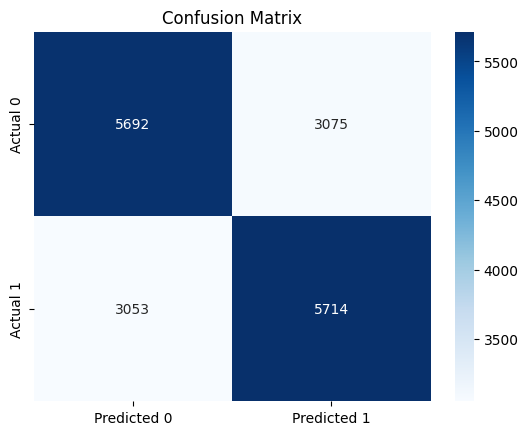

In [29]:
# Backtest
rr_predictions = backtest(processed_df, rr, rr_predictors)
score = accuracy_score(rr_predictions['actual'], rr_predictions['prediction'])
print(f'Doğruluk Oranı: %{round((score * 100), 2)}\n')

# Confusion Matrix
cm = confusion_matrix(rr_predictions['actual'], rr_predictions['prediction'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.show()

Doğruluk Oranı: %64.77



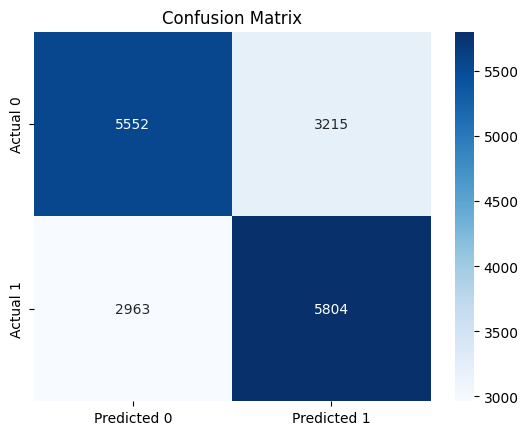

In [30]:
# Backtest
xgb_predictions = backtest(processed_df, xgb, xgb_predictors)
score = accuracy_score(xgb_predictions['actual'], xgb_predictions['prediction'])
print(f'Doğruluk Oranı: %{round((score * 100), 2)}\n')

# Confusion Matrix
cm = confusion_matrix(xgb_predictions['actual'], xgb_predictions['prediction'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.show()

Doğruluk Oranı: %64.94



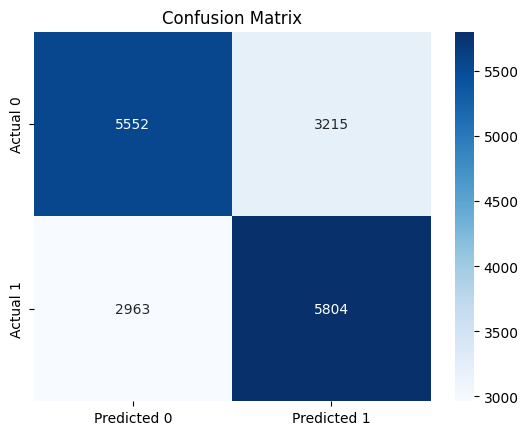

In [31]:
# Backtest
logreg_predictions = backtest(processed_df, logreg, rr_predictors)
score = accuracy_score(logreg_predictions['actual'], logreg_predictions['prediction'])
print(f'Doğruluk Oranı: %{round((score * 100), 2)}\n')

# Confusion Matrix
cm = confusion_matrix(xgb_predictions['actual'], xgb_predictions['prediction'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.show()

Doğruluk Oranı: %65.05



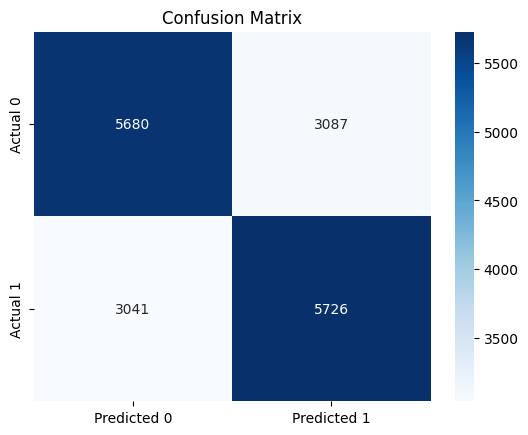

In [32]:
# Ensemble Models
predictions_df = pd.concat([rr_predictions['prediction'], xgb_predictions['prediction'], logreg_predictions['prediction']], axis=1)
ensemble_prediction = predictions_df.apply(lambda x: x.mode()[0], axis=1)

score = accuracy_score(logreg_predictions['actual'], ensemble_prediction)
print(f'Doğruluk Oranı: %{round((score * 100), 2)}\n')

# Confusion Matrix
cm = confusion_matrix(logreg_predictions['actual'], ensemble_prediction)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.show()

## Game Predictions - Results

In [33]:
def print_winner(df, prediction, games_dict):
    for key, i in zip(games_dict, range(0, int(len(prediction)), 2)):
        
        # Initialize Game info for this particular game
        home_team = games_dict[key]['home_team']
        away_team = games_dict[key]['away_team']
        game_date = games_dict[key]['game_date']
        
        home_win_pred = prediction[i]
        away_win_pred = prediction[i+1]
        
        print(f'\n\n Home Team --> {home_team} vs {away_team} <-- Away Team')
        if home_win_pred == away_win_pred:
            print(f'There is error both teams prediction seems to be same.')
        elif home_win_pred:
            print(f'\t\t{home_team} WINS!\n\n')
        elif away_win_pred: 
            print(f'\t\t{away_team} WINS!\n\n')

In [34]:
# Train the model & predict games (rr)
rr_model = rr.fit(processed_df[rr_predictors], processed_df['target'])
rr_prediction = rr_model.predict(games_df[rr_predictors])

print_winner(df, rr_prediction, games_dict)



 Home Team --> PHI vs ORL <-- Away Team
		PHI WINS!




 Home Team --> WAS vs CHI <-- Away Team
		CHI WINS!




 Home Team --> BOS vs CHO <-- Away Team
		BOS WINS!




 Home Team --> IND vs CLE <-- Away Team
		IND WINS!




 Home Team --> NYK vs BRK <-- Away Team
		NYK WINS!




In [35]:
# Train the model & predict games (xgb)
xgb_model = xgb.fit(processed_df[xgb_predictors], processed_df['target'])
xgb_prediction = xgb_model.predict(games_df[xgb_predictors])

print_winner(df, xgb_prediction, games_dict)



 Home Team --> PHI vs ORL <-- Away Team
		PHI WINS!




 Home Team --> WAS vs CHI <-- Away Team
		CHI WINS!




 Home Team --> BOS vs CHO <-- Away Team
		BOS WINS!




 Home Team --> IND vs CLE <-- Away Team
		IND WINS!




 Home Team --> NYK vs BRK <-- Away Team
		NYK WINS!




#### Precision Recall Curve

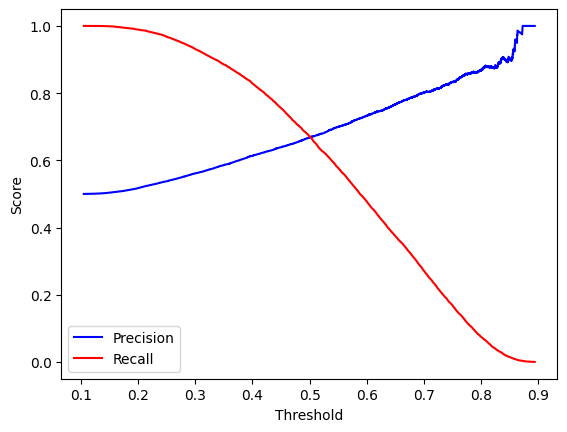

In [61]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get the prediction probabilities
xgb_probs = xgb_model.predict_proba(processed_df[xgb_predictors])

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(processed_df['target'], xgb_probs[:, 1])

# Plot precision-recall curve
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'r-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

In [62]:
threshold_80_precision = thresholds[np.argmax(precision >= 0.8)]
threshold_80_precision

0.69684964

In [63]:
recall_80_precision = recall[np.argmax(precision >= 0.8)]
recall_80_precision

0.2791922739244952

In [38]:
y_train_pred_80 = (xgb_probs[:, 1] >= threshold_80_precision)

In [39]:
from sklearn.metrics import precision_score
precision_score(processed_df['target'], y_train_pred_80)

0.8

In [40]:
xgb_probs = xgb_model.predict_proba(games_df[xgb_predictors])

In [41]:
xgb_probs

array([[0.45918638, 0.5408136 ],
       [0.5186678 , 0.4813322 ],
       [0.7423264 , 0.2576736 ],
       [0.25452006, 0.74547994],
       [0.17926288, 0.8207371 ],
       [0.840448  , 0.15955196],
       [0.27444297, 0.725557  ],
       [0.6672943 , 0.33270568],
       [0.17348534, 0.82651466],
       [0.796654  , 0.203346  ]], dtype=float32)

In [42]:
winners = xgb_probs[:, 1] > threshold_80_precision

In [43]:
winners

array([False, False, False,  True,  True, False,  True, False,  True,
       False])

# Elo Graph

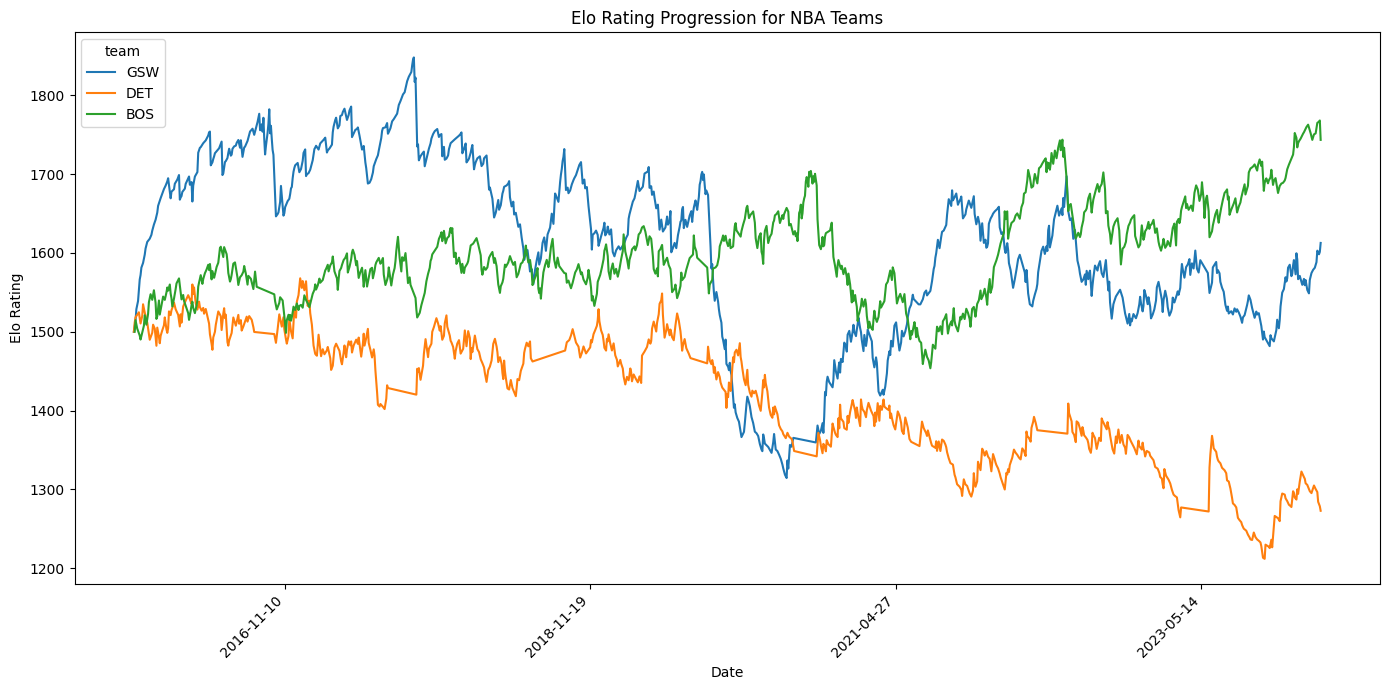

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

plot_df = elo_df[(elo_df['team'] == 'BOS') | (elo_df['team'] == 'DET') |  (elo_df['team'] == 'GSW')]

# Create the plot
plt.figure(figsize=(14, 7))

# Plot using seaborn
sns.lineplot(x='date', y='elo_pre_game', hue='team', data=plot_df, marker=' ', markersize=5, legend='brief')

# Improve x-axis labels
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))  # Show a tick every 3 months
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show the tick in 'Year' format
plt.xticks(rotation=45, ha='right')  # Rotate the labels for better readability

plt.title('Elo Rating Progression for NBA Teams')
plt.xlabel('Date')
plt.ylabel('Elo Rating')
plt.tight_layout()

# Show the plot
plt.show()


# Neural Network

In [45]:
rr_predictors = ['orb_max', 'ast%_max', '3p%_opp', 'ft%_opp', 'drb_opp', 'ts%_opp', 'orb%_opp', 'trb%_opp', '3pa_10_x', 'ast_10_x', 'ft_max_10_x',
             'pts_max_10_x', 'orb%_max_10_x', 'drb%_max_10_x', 'blk%_opp_10_x', 'orb_max_opp_10_x', 'fg_10_y', '3pa_10_y', 'ft_max_10_y', 
             '3p%_opp_10_y', 'ft_opp_10_y', 'blk%_opp_10_y', 'ft_max_opp_10_y', '+/-_max_opp_10_y', 'total_opp_10_y', 'wr_against_team_opp_next',
             'home_next', 'hot', 'cold', 'efg%_20_x',
             '3pa_20_x', 'ast_20_x', 'ft_max_20_x', 'pts_max_20_x', 'orb%_max_20_x', 'drb%_max_20_x', 'blk%_opp_20_x','orb_max_opp_20_x',
             'total_opp_20_x', 'fg_20_y', '3pa_20_y', 'ft_max_20_y', 'pts_max_20_y', 'ast%_max_20_y', '3p%_opp_20_y', 'ft_opp_20_y', 'blk%_opp_20_y',
             'ft_max_opp_20_y', '+/-_max_opp_20_y', 'total_opp_20_y', '+/-_max_20_x',  '+/-_max_20_y', '+/-_max_opp_20_x', 'drtg_max_opp_20_x',
             '+/-_max_10_x', '+/-_max_10_y', '+/-_max_opp_10_x', 'drtg_max_opp_10_x', 'efg%_10_x', 'elo_pre_game_x', 'elo_pre_game_y',
             ]

xgb_predictors = [
       'elo_pre_game_y', 'elo_pre_game_x', '+/-_max_20_y', '+/-_max_opp_20_y',
       '+/-_max_opp_20_x', '+/-_max_20_x', '+/-_max_opp_10_y', '+/-_max_10_y',
       'home_next', '+/-_max_10_x', '+/-_max_opp_10_x', 'pts_max_20_y',
       'efg%_20_x', 'total_opp_20_x', 'ast%_max_20_y', 'drtg_max_opp_20_x',
       'efg%_10_x', 'ast%_max', 'blk%_opp_20_y', 'blk%_opp_20_x',
       'blk%_opp_10_y', 'ft%_opp', '3p%_opp_10_y', '3p%_opp_20_y',
       'pts_max_20_x', 'trb%_opp', 'drb%_max_10_x', 'blk%_opp_10_x',
       'drtg_max_opp_10_x', 'total_opp_20_y', 'home_away_wr_x_wr_against_next_opp', 'wr_against_team_opp_next'
]

best_nn_predictors = ['wr_against_team_opp_next', 'home_away_wr_x_wr_against_next_opp', 'home_next',
                 'elo_pre_game_x', 'elo_pre_game_y', 'elo_difference',
                 'total_20_x', 'total_20_y',
                 'fg%_20_x', 'fg%_20_y',
                 '3p%_20_x', '3p%_20_y',
                 'ft%_20_y', 'ft%_20_y',
                 'trb_20_x', 'trb_20_y',
                 'ast_20_x', 'ast_20_y',
                 'tov_20_x', 'tov_20_y',
                 '3p%_20_x', '3p%_20_y', 
                 'drtg_20_x', 'drtg_20_y']

nn_predictors = ['wr_against_team_opp_next', 'home_away_wr_x_wr_against_next_opp', 'home_next',
                 'elo_pre_game_x', 'elo_pre_game_y',
                 'total_20_x', 'total_20_y',
                 'fg%_20_x', 'fg%_20_y',
                 '3p%_20_x', '3p%_20_y',
                 'ft%_20_y', 'ft%_20_y',
                 'trb_20_x', 'trb_20_y',
                 'ast_20_x', 'ast_20_y',
                 'tov_20_x', 'tov_20_y',
                 'stl_20_x', 'stl_20_y',
                 'blk_20_x', 'blk_20_y',
                 'elo_difference'
                 #'+/-_max_20_x', '+/-_max_20_y'
                ]

In [46]:
processed_df_ = processed_df[processed_df['season'] > 2016] # For elo ratings to be proper

In [47]:
removed_columns = list(processed_df_.columns[processed_df_.dtypes == 'object']) +  list(['date', 'season', 'won', 'team', 'team_opp'])
selected_columns = processed_df_.columns[~processed_df_.columns.isin(removed_columns)]

new_df = processed_df_[best_nn_predictors + ['target']]

total_rows = new_df.shape[0]
train_split = int(total_rows * 0.75)  # 70% of data for training
val_split = train_split + int(total_rows * 0.15)  # Additional 15% for validation

# Split the data
train_data = new_df.iloc[:train_split]
val_data = new_df.iloc[train_split:val_split]
test_data = new_df.iloc[val_split:]

# Extract features and target
X_train, y_train = train_data.drop(['target'], axis=1), train_data['target']
X_val, y_val = val_data.drop(['target'], axis=1), val_data['target']
X_test, y_test = test_data.drop(['target'], axis=1), test_data['target']


In [58]:
removed_columns = list(processed_df.columns[processed_df.dtypes == 'object']) +  list(['date', 'season', 'won', 'team', 'team_opp'])
selected_columns = processed_df.columns[~processed_df.columns.isin(removed_columns)]

new_df = processed_df[nn_predictors + ['target']]

total_rows = new_df.shape[0]
train_split = int(total_rows * 0.75)  # 70% of data for training
val_split = train_split + int(total_rows * 0.15)  # Additional 15% for validation

# Split the data
train_data = new_df.iloc[:train_split]
val_data = new_df.iloc[train_split:val_split]
test_data = new_df.iloc[val_split:]

# Extract features and target
X_train, y_train = train_data.drop(['target'], axis=1), train_data['target']
X_val, y_val = val_data.drop(['target'], axis=1), val_data['target']
X_test, y_test = test_data.drop(['target'], axis=1), test_data['target']


In [48]:
X_train.shape[0]

15114

In [49]:
X_train.shape[1]

24

In [50]:
from tensorflow.keras.regularizers import l2
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Use the Input layer to specify the input shape
    Dense(12, activation='tanh', kernel_regularizer = l2(0.02876)),
    Dropout(0.2),
    Dense(6, activation='tanh', kernel_regularizer = l2(0.02875)),
    Dropout(0.08),
    Dense(1, activation='sigmoid')
])

optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'], )

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              78 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=16, 
                    validation_data=(X_val, y_val),
                    verbose=1)

# Evaluate the model on the test set
model.evaluate(X_test, y_test, verbose=2)

Epoch 1/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.5275 - loss: 1.0499 - val_accuracy: 0.6059 - val_loss: 0.7004
Epoch 2/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - accuracy: 0.6249 - loss: 0.6907 - val_accuracy: 0.5897 - val_loss: 0.6932
Epoch 3/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - accuracy: 0.6243 - loss: 0.6819 - val_accuracy: 0.6056 - val_loss: 0.6877
Epoch 4/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - accuracy: 0.6364 - loss: 0.6733 - val_accuracy: 0.6135 - val_loss: 0.6828
Epoch 5/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - accuracy: 0.6396 - loss: 0.6695 - val_accuracy: 0.6244 - val_loss: 0.6778
Epoch 6/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step - accuracy: 0.6441 - loss: 0.6633 - val_accuracy: 0.6128 - val_loss: 0.6775
Epoch 7/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - accuracy: 0.6380 - loss: 0.6633 - val_accuracy: 0.6211 - val_loss: 0.6744
Epoch 8/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - accuracy: 0.6369 - loss: 0

[0.6220629215240479, 0.6572420597076416]

630/630 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


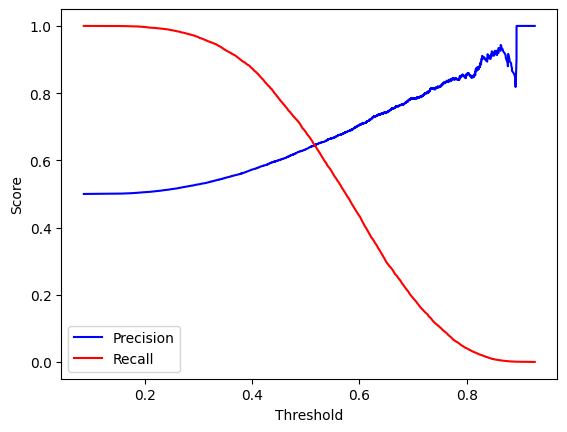

In [52]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get the prediction probabilities
nn_probas = model.predict(processed_df_[best_nn_predictors])

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(processed_df_['target'], nn_probas)

# Plot precision-recall curve
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'r-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

In [53]:
threshold_80_precision = thresholds[np.argmax(precision >= 0.8)]
threshold_80_precision

0.72289723

In [58]:
recall_80_precision = recall[np.argmax(precision >= 0.8)]
recall_80_precision

0.14689826302729528

In [54]:
nn_prediction = model.predict(games_df[best_nn_predictors])
predicted_labels = ((nn_prediction > threshold_80_precision).astype(int)).flatten()
print_winner(df, predicted_labels, games_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 Home Team --> PHI vs ORL <-- Away Team
There is error both teams prediction seems to be same.


 Home Team --> WAS vs CHI <-- Away Team
There is error both teams prediction seems to be same.


 Home Team --> BOS vs CHO <-- Away Team
		BOS WINS!




 Home Team --> IND vs CLE <-- Away Team
There is error both teams prediction seems to be same.


 Home Team --> NYK vs BRK <-- Away Team
		NYK WINS!




In [55]:
nn_prediction

array([[0.5542276 ],
       [0.47844824],
       [0.38959566],
       [0.6330606 ],
       [0.9044256 ],
       [0.10898928],
       [0.68088627],
       [0.34665847],
       [0.74510515],
       [0.2789716 ]], dtype=float32)

In [69]:
games_df['nn_preds'] = nn_prediction.flatten()